#### Create Zarr Array


In [8]:
import os
import os.path as osp
import time
import pickle as pkl
import numpy as np
from PIL import Image
import torch
import zarr
from tqdm import tqdm



from modules.utils.image_utils import to_tensor, transform, transform_visualize, crop_box, plot_tensor
from modules.utils.data_utils import get_relevant_keypoints

In [14]:
def save_img_zarr(root_path:str,
                  zarr_path:str=None,
                  split:str = 'train',
                  num_required_keypoints: int = 0,):
    sequence_path = osp.join(root_path, 'sequenceFiles', split)
    seq_names = [seq_name.split('.pkl')[0] for seq_name in sorted(os.listdir(sequence_path))]
    num_required_keypoints = 8
    image_paths = []
    person_ids = []
    sequences = {}
    for seq_name in seq_names:
        ## loop through all sequences and filter out those where kp are missing
        img_dir = osp.join(root_path, 'imageFiles', seq_name)

        seq_file_name = os.path.join(sequence_path, f'{seq_name}.pkl')
        with open(seq_file_name, 'rb') as f:
            seq = pkl.load(f, encoding='latin1')
        sequences[seq_name] = seq
        num_people = len(seq['poses'])

        for img_idx, img_name in enumerate(sorted(os.listdir(img_dir))):
            ## for each person: save img_path 
            image_path = osp.join(img_dir,img_name)
            for person_id in range(num_people):
                pose2d = seq['poses2d'][person_id][img_idx]
                relevant_poses2d = get_relevant_keypoints(pose2d)
                if len(relevant_poses2d) >= num_required_keypoints:
                    image_paths.append(image_path)
                    person_ids.append(person_id)

    # create imgsx3x244x244  zarr array    
    if zarr_path is None:
        zarr_path = osp.join("../../data", "imgs_3dpw", f'{num_required_keypoints}_kps', split, ".zarr")
        
    img_zarr = zarr.open(zarr_path, mode='w', shape=(len(image_paths), 3, 224, 224), chunks=(len(image_paths)//10, None), dtype='float32')

    for index, img_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        ## for each img: save tranformed img in zarr array
        _, img_name = os.path.split(img_path)
        img = np.array(Image.open(img_path))
        img_tensor = to_tensor(img)

        seq_name = img_path.split('/')[-2]
        seq = sequences[seq_name]     
        index_seq = int((img_name.split('.')[0]).split('_')[1])
        person_id = person_ids[index]
        poses2d = torch.tensor(seq['poses2d'][person_id][index_seq], dtype=torch.float32)

        img_tensor, _ = crop_box(img_tensor=img_tensor, pose2d=poses2d)

        img_tensor = transform(img_tensor)
        img_zarr[index] = img_tensor




In [ ]:
save_img_zarr(root_path='../3DPW', zarr_path='data/test.zarr', num_required_keypoints=8,split='train')

  0%|          | 13/22727 [00:40<18:49:43,  2.98s/it]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


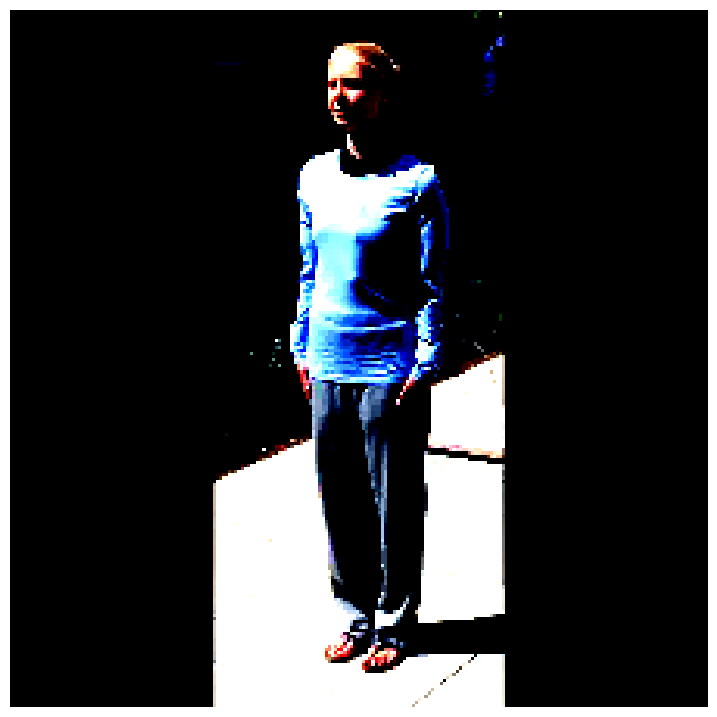

In [27]:
plot_tensor(torch.from_numpy(img_zarr[0]))

In [21]:
test_zarr = zarr.load('data/imgs_3dpw_test.zarr')[:300].copy()

In [23]:
zarr.save('data/imgs_3dpw_test.zarr', test_zarr)